# Lab 3: Filter Design

## 1. A Notch Digital Filter 

A simple notch filter has a z-transform: 

$$ W(z) = MF(z)F(z*)* = M\frac{z-q}{z-p}\frac{z-q*}{z-p*}$$

where M is 1.05 (the normalization factor, $ q = e^{-i2\pi f_0 / f_s} $, $ p = (1+\epsilon)q $, $ f_s $ is the sampling rate where $ f_s = \frac{1}{\Delta}$ = 12 cycles/year, $ f_0 $ is the rejection frequency, $ f_0 $ = 1 cycle / year and $ \epsilon = 0.05$

The poles of this system are p and p* while the zeros are q and q*. Zeros are located on the unit circle while the poles are outside the unit circle. This is a stable system as the output is bounded and the filter is real. 

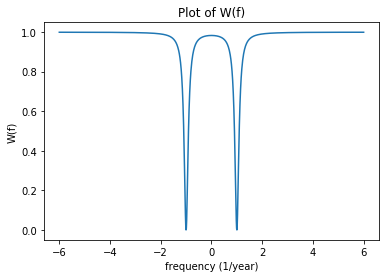

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.signal as scis

f_0 = 1
f_s = 12
eps = 0.05
M = 1.05

q = np.exp(-1j*2*np.pi*f_0/f_s)
p = (1+eps)*q

def W(z):
    return M*((z-q)*(z-np.conj(q)))/((z-p)*(z-np.conj(p)))

f= np.linspace(-f_s/2, f_s/2, 1000)

z= np.exp(-1j*2*np.pi*f/f_s)

W_f = W(z)*np.conj(W(z))

plt.plot(f, W_f)
plt.xlabel("frequency (1/year)")
plt.ylabel("W(f)")
plt.title("Plot of W(f)")
plt.show()

The FWHM of the plot is about 0.20. The FWHM can be changed by decreasing the sampling rate or decreasing the epsilon value in p. 

## 2. Implementing the Notch Filter

The notch filter above can be implemented as two filters: a numerator filter, and a denominator filter. This can be written out fully as:

$$ W(z) = \frac{N(z)}{D(z)}= \frac{a + bz + cz^2}{1 + Bz + Cz^2} $$

where $ a= M \frac{qq*}{pp*}, b= -M\frac{q+q*}{pp*}, c=\frac{M}{pp*}, C=\frac{1}{pp*}, B= -\frac{p+p*}{pp*}$

Decreasing the FWHM should decrease the impulse response as there are less frequencies being superimposed and the response would be to just one frequency. 

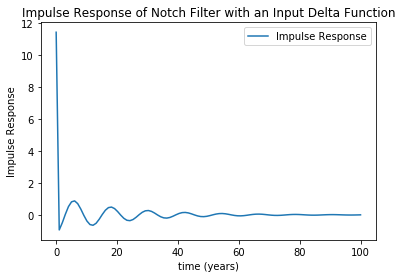

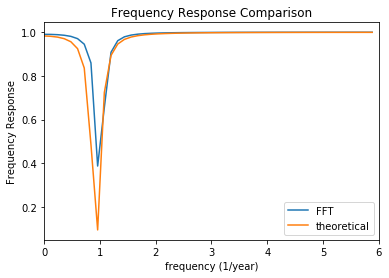

In [2]:
dt = 1/f_s

a= M*q*np.conj(q)/(p*np.conj(p))
b= -M*(q + np.conj(q))/(p*np.conj(p))
c= M / (p*np.conj(p))

C= 1 / (p*np.conj(p))
B= -(p + np.conj(p))/(p*np.conj(p))

N_coeff= [a, b, c]
D_coeff= [1, B, C]

def ratFilter(N,D,x):   
    inv = []
    conv = np.convolve(x, N)
    a_0 = D[0]
    inv.append(conv[0]/a_0)   
    for i in range(1, len(conv) - len(D) + 1):
        inv.append((conv[i]- np.convolve(inv,D)[i])/a_0)
    [x, y] = [x, inv]
    return [x,y]

#Impulse array
time_array = np.linspace(0, 100, 100)
delta_array = scis.unit_impulse(100)/dt
x = delta_array

[x,y]= ratFilter(N_coeff, D_coeff, x)

#plt.plot(time_array, delta_array, label= "Delta Function")
plt.plot(time_array, y, label = "Impulse Response")
plt.ylabel("Impulse Response")
plt.xlabel("time (years)")
plt.title("Impulse Response of Notch Filter with an Input Delta Function")
plt.legend()
plt.show()

fft_y = np.fft.fftshift(np.fft.fft(np.fft.fftshift(y)))*dt 
f_axis = np.fft.fftshift(np.fft.fftfreq(len(fft_y),dt))

f= np.linspace(-f_s/2, f_s/2, 100)
z= np.exp(-1j*2*np.pi*f/f_s)
y_1= W(z)*np.conj(W(z))

plt.plot(f_axis, np.abs(fft_y), label ="FFT")
plt.plot(f_axis, np.abs(y_1), label="theoretical")
plt.ylabel("Frequency Response")
plt.xlabel("frequency (1/year)")
plt.xlim(0,6)
plt.title("Frequency Response Comparison")
plt.legend()
plt.show()

## 3. The Mauna Loa CO2 Data

Below is carbon dioxide values (in PPM) measured every month at the Mauna Loa Observatory from January 1965 to December 2003. The annual oscillation was removed from the trend. 

In [3]:
co2Values = np.array([
    [319.44, 320.44, 320.89, 322.13, 322.16, 321.87, 321.21, 318.87, 317.81, 317.30, 318.87, 319.42],
    [320.62, 321.59, 322.39, 323.70, 324.07, 323.75, 322.40, 320.37, 318.64, 318.10, 319.79, 321.03],
    [322.33, 322.50, 323.04, 324.42, 325.00, 324.09, 322.55, 320.92, 319.26, 319.39, 320.72, 321.96],
    [322.57, 323.15, 323.89, 325.02, 325.57, 325.36, 324.14, 322.11, 320.33, 320.25, 321.32, 322.90],
    [324.00, 324.42, 325.64, 326.66, 327.38, 326.70, 325.89, 323.67, 322.38, 321.78, 322.85, 324.12],
    [325.06, 325.98, 326.93, 328.13, 328.07, 327.66, 326.35, 324.69, 323.10, 323.07, 324.01, 325.13],
    [326.17, 326.68, 327.18, 327.78, 328.92, 328.57, 327.37, 325.43, 323.36, 323.56, 324.80, 326.01],
    [326.77, 327.63, 327.75, 329.72, 330.07, 329.09, 328.05, 326.32, 324.84, 325.20, 326.50, 327.55],
    [328.54, 329.56, 330.30, 331.50, 332.48, 332.07, 330.87, 329.31, 327.51, 327.18, 328.16, 328.64],
    [329.35, 330.71, 331.48, 332.65, 333.09, 332.25, 331.18, 329.40, 327.44, 327.37, 328.46, 329.58],
    [330.40, 331.41, 332.04, 333.31, 333.96, 333.59, 331.91, 330.06, 328.56, 328.34, 329.49, 330.76],
    [331.74, 332.56, 333.50, 334.58, 334.87, 334.34, 333.05, 330.94, 329.30, 328.94, 330.31, 331.68],
    [332.92, 333.42, 334.70, 336.07, 336.74, 336.27, 334.93, 332.75, 331.58, 331.16, 332.40, 333.85],
    [334.97, 335.39, 336.64, 337.76, 338.01, 337.89, 336.54, 334.68, 332.76, 332.54, 333.92, 334.95],
    [336.23, 336.76, 337.96, 338.89, 339.47, 339.29, 337.73, 336.09, 333.91, 333.86, 335.29, 336.73],
    [338.01, 338.36, 340.08, 340.77, 341.46, 341.17, 339.56, 337.60, 335.88, 336.01, 337.10, 338.21],
    [339.23, 340.47, 341.38, 342.51, 342.91, 342.25, 340.49, 338.43, 336.69, 336.85, 338.36, 339.61],
    [340.75, 341.61, 342.70, 343.56, 344.13, 343.35, 342.06, 339.82, 337.97, 337.86, 339.26, 340.49],
    [341.37, 342.52, 343.10, 344.94, 345.75, 345.32, 343.99, 342.39, 339.86, 339.99, 341.16, 342.99],
    [343.70, 344.51, 345.28, 347.08, 347.43, 346.79, 345.40, 343.28, 341.07, 341.35, 342.98, 344.22],
    [344.97, 346.00, 347.43, 348.35, 348.93, 348.25, 346.56, 344.69, 343.09, 342.80, 344.24, 345.56],
    [346.29, 346.96, 347.86, 349.55, 350.21, 349.54, 347.94, 345.91, 344.86, 344.17, 345.66, 346.90],
    [348.02, 348.47, 349.42, 350.99, 351.84, 351.25, 349.52, 348.10, 346.44, 346.36, 347.81, 348.96],
    [350.43, 351.72, 352.22, 353.59, 354.22, 353.79, 352.39, 350.44, 348.72, 348.88, 350.07, 351.34],
    [352.76, 353.07, 353.68, 355.42, 355.67, 355.13, 353.90, 351.67, 349.80, 349.99, 351.30, 352.53],
    [353.66, 354.70, 355.39, 356.20, 357.16, 356.22, 354.82, 352.91, 350.96, 351.18, 352.83, 354.21],
    [354.72, 355.75, 357.16, 358.60, 359.34, 358.24, 356.17, 354.03, 352.16, 352.21, 353.75, 354.99],
    [355.98, 356.72, 357.81, 359.15, 359.66, 359.25, 357.03, 355.00, 353.01, 353.31, 354.16, 355.40],
    [356.70, 357.16, 358.38, 359.46, 360.28, 359.60, 357.57, 355.52, 353.70, 353.98, 355.33, 356.80],
    [358.36, 358.91, 359.97, 361.26, 361.68, 360.95, 359.55, 357.49, 355.84, 355.99, 357.58, 359.04],
    [359.96, 361.00, 361.64, 363.45, 363.79, 363.26, 361.90, 359.46, 358.06, 357.75, 359.56, 360.70],
    [362.05, 363.25, 364.03, 364.72, 365.41, 364.97, 363.65, 361.49, 359.46, 359.60, 360.76, 362.33],
    [363.18, 364.00, 364.57, 366.35, 366.79, 365.62, 364.47, 362.51, 360.19, 360.77, 362.43, 364.28],
    [365.32, 366.15, 367.31, 368.61, 369.29, 368.87, 367.64, 365.77, 363.90, 364.23, 365.46, 366.97],
    [368.15, 368.87, 369.59, 371.14, 371.00, 370.35, 369.27, 366.94, 364.63, 365.12, 366.67, 368.01],
    [369.14, 369.46, 370.52, 371.66, 371.82, 371.70, 370.12, 368.12, 366.62, 366.73, 368.29, 369.53],
    [370.28, 371.50, 372.12, 372.87, 374.02, 373.30, 371.62, 369.55, 367.96, 368.09, 369.68, 371.24],
    [372.43, 373.09, 373.52, 374.86, 375.55, 375.41, 374.02, 371.49, 370.71, 370.25, 372.08, 373.78],
    [374.68, 375.63, 376.11, 377.65, 378.35, 378.13, 376.62, 374.50, 372.99, 373.00, 374.35, 375.70]
])

# convert date table to a data vector
co2Data = co2Values.flatten()

# hint: to generate time vector: 
# time=linspace(co2TimeRange(0),co2TimeRange(1),length(co2Data));
co2TimeRange = [1965.0417, 2003.9583]


#Notes:
#Monthly values are expressed in parts per million (ppm) and reported in the 2003A SIO manometric mole 
#fraction scale.  The monthly values have been adjusted to the 15th of each month.  Missing values are 
#denoted by -99.99. The "annual" average is the arithmetic mean of the twelve monthly values. In years 
#with one or two missing monthly values, annual values were calculated by substituting a fit value 
#(4-harmonics with gain factor and spline) for that month and then averaging the twelve monthly values.
#Data were obtained from
#http://cdiac.esd.ornl.gov/ftp/trends/co2/maunaloa.co2

### Plots of Original Data and Detrended Data

Before we begin to remove the annual oscillations, we need to remove the clearly rising trend in atmospheric CO2. Both the original data and detrended data are plotted below:

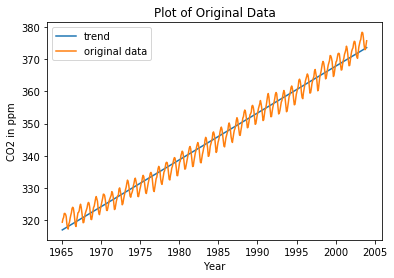

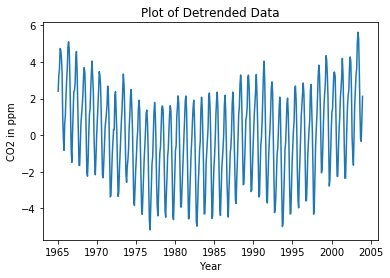

In [4]:
time = np.linspace(co2TimeRange[0],co2TimeRange[1],len(co2Data))
dt = time[1]-time[0]

coeff = np.polyfit(time, co2Data,1)

trend=time*coeff[0] + coeff[1]

plt.plot(time, trend, label="trend")
plt.plot(time, co2Data, label = "original data")
plt.title("Plot of Original Data")
plt.xlabel("Year")
plt.ylabel("CO2 in ppm")
plt.legend()
plt.show()


detrend = co2Data - trend
plt.plot(time, detrend)
plt.title("Plot of Detrended Data")
plt.xlabel("Year")
plt.ylabel("CO2 in ppm")
plt.show()

### Application of Notch Filter to Detrended data

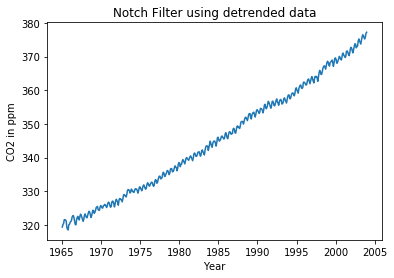

In [5]:
[x,y]= ratFilter(N_coeff, D_coeff, detrend)

plt.plot(time, np.abs(y + trend))
plt.title("Notch Filter using detrended data")
plt.xlabel("Year")
plt.ylabel("CO2 in ppm")
plt.show()

### Removing annual oscillations without Notch Filter 

To remove annual oscillations, the detrended data undergoes a FFT and frequencies above 0.9 are removed as that corresponds to annual oscillations. An IFFT is taken and the trend is added back into the data so that we can get a sense of what is happening without annual oscillations. Comparing the two different methods, it appears that using the FFT method results in cleaner data, but it takes away obvious oscillations. Using the notch filter, is a lot quicker and provides a plot that is similar to the FFT, with the oscillations still apparent.  

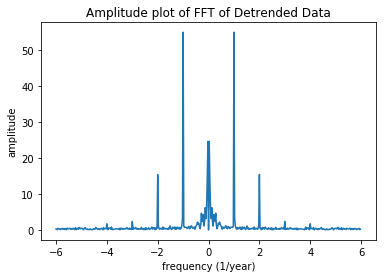

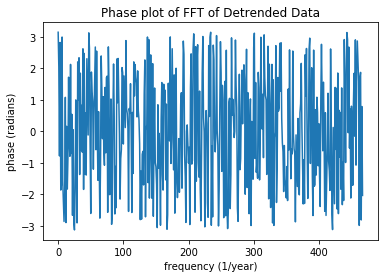

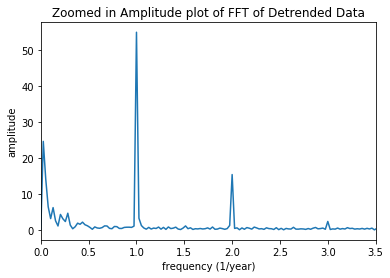

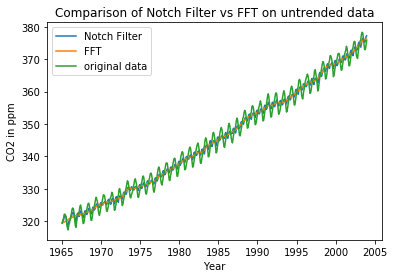

In [6]:
transform = np.fft.fftshift(np.fft.fft(np.fft.fftshift(detrend)))*dt
f_axis = np.fft.fftshift(np.fft.fftfreq(len(detrend),dt))

plt.plot(f_axis,np.abs(transform))
plt.title("Amplitude plot of FFT of Detrended Data")
plt.xlabel("frequency (1/year)")
plt.ylabel("amplitude")
plt.show()

plt.title("Phase plot of FFT of Detrended Data")
plt.plot(np.angle(transform))
plt.xlabel("frequency (1/year)")
plt.ylabel("phase (radians)")
plt.show()

plt.plot(f_axis,np.abs(transform))
plt.xlim(0,3.5)
plt.title("Zoomed in Amplitude plot of FFT of Detrended Data")
plt.xlabel("frequency (1/year)")
plt.ylabel("amplitude")
plt.show()

#Setting frequencies above 0.9 to zero 
for i in range(len(f_axis)):
    if f_axis[i] > 0.9 or f_axis[i] < -0.9:
        transform[i]=0

        inv_transform = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(transform)))/dt

plt.plot(time, np.abs(y + trend), label = "Notch Filter")
plt.plot(time, np.abs(inv_transform + trend), label = "FFT")
plt.plot(time, co2Data, label = "original data")

plt.title("Comparison of Notch Filter vs FFT on untrended data")
plt.xlabel("Year")
plt.ylabel("CO2 in ppm")
plt.legend()
plt.show()

### Effect of not detrending data before removing annual oscillations 

The procedure above is repeated, but this time the data is not detrended before annual oscillations are removed. We can immediately see that detrending is essential as it prevents end-to-end discontinuities in the FFT. It becomes especially prevelant when the ifft is applied and we look at the opposite ends of the data plot.  

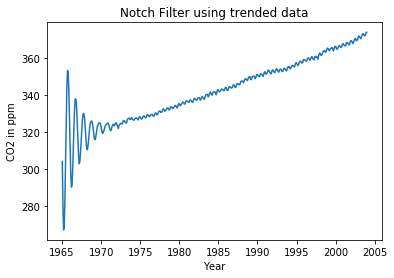

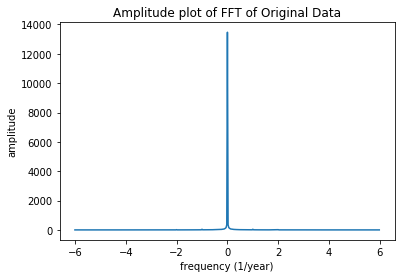

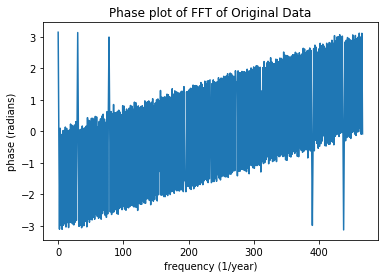

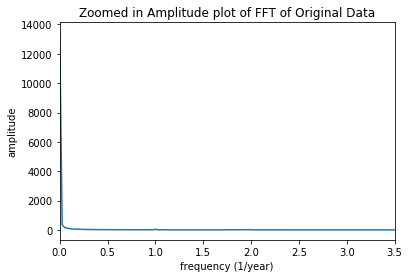

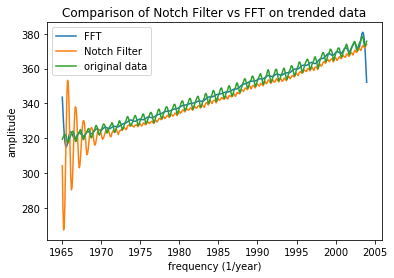

In [7]:
[x,y]= ratFilter(N_coeff, D_coeff, co2Data)
plt.plot(time, np.abs(y))
plt.title("Notch Filter using trended data")
plt.xlabel("Year")
plt.ylabel("CO2 in ppm")
plt.show()

transform_trend = np.fft.fftshift(np.fft.fft(np.fft.fftshift(co2Data)))*dt
f_axis_trend = np.fft.fftshift(np.fft.fftfreq(len(co2Data),dt))

plt.plot(f_axis_trend,np.abs(transform_trend))
plt.title("Amplitude plot of FFT of Original Data")
plt.xlabel("frequency (1/year)")
plt.ylabel("amplitude")
plt.show()

plt.title("Phase plot of FFT of Original Data")
plt.plot(np.angle(transform_trend))
plt.xlabel("frequency (1/year)")
plt.ylabel("phase (radians)")
plt.show()

plt.plot(f_axis_trend,np.abs(transform_trend))
plt.title("Zoomed in Amplitude plot of FFT of Original Data")
plt.xlabel("frequency (1/year)")
plt.ylabel("amplitude")
plt.xlim(0,3.5)
plt.show()

for i in range(len(f_axis_trend)):
    if f_axis_trend[i] > 0.9 or f_axis_trend[i] < -0.9:
        transform_trend[i]=0

inv_transform_trend = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(transform_trend)))/dt

plt.plot(time, abs(inv_transform_trend), label = "FFT")
plt.plot(time, np.abs(y), label = "Notch Filter")
plt.plot(time, co2Data, label = "original data")
plt.xlabel("frequency (1/year)")
plt.ylabel("amplitude")
plt.title("Comparison of Notch Filter vs FFT on trended data")
plt.legend()
plt.show()